### 以MountainCar学习控制问题为例，将动作值函数离散化并表示为表格。实现一个学习控制器，使RBF模型以两种不同的方式逼近值函数:

### 1 通过表格离散化方法得到学习的值函数。用不同数量的基函数建立一个RBF逼近器，看看从这个逼近中得到的策略是否能够把车开到山顶。近似值的精度如何随着使用的基函数的数量而变化?

#### 首先使用Q-learning或SARSA更新方法得到一个Q-table

In [1]:
# gym enviroment setup

import gym
import pygame
import numpy as np
import matplotlib.pyplot as plt

env = gym.make("MountainCar-v0")
state,_ = env.reset()

# Q Table setup
LEARNING_RATE = 0.5
DISCOUNT = 0.95
EPISODES = 1000
Q_TABLE_LEN = 20

DISCRETE_OS_SIZE = [Q_TABLE_LEN] * len(env.observation_space.high) 
# self.high = np.array([self.max_position, self.max_speed])
# [20] * 2 = [20, 20]
discrete_os_win_size = (env.observation_space.high - env.observation_space.low) / DISCRETE_OS_SIZE
# discrete_os_win_size = array([0.09 , 0.007])


# decay epsilon
epsilon = 1
START_EPSILON_DECAYING = 1
END_EPSILON_DECAYING = EPISODES // 2 # //表示整数除法
epsilon_decay_value = epsilon / (END_EPSILON_DECAYING - START_EPSILON_DECAYING)


def get_discrete_state(state):
    discrete_state = (state - env.observation_space.low) // discrete_os_win_size
    return tuple(discrete_state.astype(int))


def take_epsilon_greedy_action(q_table, state, epsilon):
    if np.random.random() < epsilon:
        action = np.random.randint(0, env.action_space.n)
    else:
        action = np.argmax(q_table[get_discrete_state(state)])
    return action

def q_learning(env, episodes, discount, epsilon, alpha):
    q_table = np.zeros((DISCRETE_OS_SIZE + [env.action_space.n]))
    # q_table.shape = (20, 20, 3)
    for episode in range(episodes):
        state, _ = env.reset()
        total_reward =0 
        while(True):
            action = take_epsilon_greedy_action(q_table, state, epsilon)
            next_state, reward, terminated, truncated, info = env.step(action)
            # 'done' 现在被分成 'terminated' 和 'truncated'。只要episode由于任何原因结束（任务完成或步数限制），done 就会被设置为True，这与旧版本的gym中done的用法一致
            done = terminated or truncated
            total_reward+=reward
            best_next_action = np.argmax(q_table[get_discrete_state(next_state)])

            td_target = reward + discount * q_table[get_discrete_state(next_state)][best_next_action]
            q_table[get_discrete_state(state)][action] += alpha * (td_target - q_table[get_discrete_state(state)][action])
            if next_state[0] >= 0.5:
                q_table[get_discrete_state(state)][action] = 0
                break
            state = next_state
            action = best_next_action
            if episode >= START_EPSILON_DECAYING and episode <= END_EPSILON_DECAYING:
                epsilon -= epsilon_decay_value
#         print(episode, total_reward)
    return q_table

q_table = q_learning(env, EPISODES, DISCOUNT, epsilon, LEARNING_RATE)

#### 用RBF来拟合得到的Q-table。
1. 首先把[n_pos, n_vel, q_value] (这里为 (20, 20, 3))的Q-table变形。对于3个不同的actions， 我们都有N\*N的二维表格，表现有N\*N个states。如果把这个二维表格用x轴和y轴表示，则可以转化为N\*N行，2列的形式。每个state都对应3个action的q-value。所以整个Q-table可以转化为N\*N行，竖列分别为（x轴，y轴，q_0, q_1, q_2）的形式来表示。
2. 因为我们要使用RBF来拟合q-value值，则输入为每一个state。所以我们将前两列设置为输入X， 后三列设置为输出y。
3. 使用KMeans方法来找出J个中心点，并构造大小为（states的个数 * J）的design matrix. 
4. 使用最小二乘法求出weight。
$ w = (U^TU)^{-1}U^Ty$

In [7]:
# 我们已经得到了q_table，然后把得到的Q-table转化成 [pos_axis, vel_axis, q_0, q_1, q_2] 的形式
q_t = []

for i in range(0,Q_TABLE_LEN): 
    for j in range(0,Q_TABLE_LEN):  
        q_t.append([i,j,q_table[i][j][0],q_table[i][j][1],q_table[i][j][2]])
         
q_t=np.array(q_t) 
X = q_t[:, :2] 
y = q_t[:, -3:] 

# RBF
from sklearn.cluster import KMeans
J = 20
kmeans = KMeans(n_clusters=J, random_state=0).fit(X) 
sig = np.std(X)  

# Construct design matrix
U = np.zeros((len(q_t),J))  

for i in range(len(q_t)): 
    for j in range(J): 
        U[i][j] = np.exp(-(np.linalg.norm(X[i] - kmeans.cluster_centers_[j]))**2/(2*sig**2))


w_rbf = np.dot(np.dot((np.linalg.inv(np.dot(U.T,U))), U.T) , y) 
yh_rbf = np.dot(U,w_rbf) 

#print('norm', np.linalg.norm(y-yh_rbf) )


#### 测试从这个逼近器中得到的策略是否能够把车开到山顶
- 用J维的design matrix与求得的weight相乘，得到三个actions对应的三个q-values。 $y_{rbf} = U*w$
- （index为把2维图表中的state值转化为总states当中的第index个states）

In [3]:
import gym
import numpy as np
import pygame
import sys

env = gym.make("MountainCar-v0", render_mode="human")
# env = gym.make("MountainCar-v0", render_mode="rgb_array")
# env = env.unwrapped

for episode in range(3):
    obs,_ = env.reset()

    while True:
        pos, vel = get_discrete_state(obs) 
        index = Q_TABLE_LEN * pos + vel+1
        action = np.argmax(np.dot(U[index], w_rbf))
        # obs,_,done,_ = env.step(action)   
        obs, _, terminated, truncated, _ = env.step(action) 
        done = terminated or truncated  # 判断是否结束
        env.render()
        if done: 
            break
       
env.close()
pygame.quit()

#### 近似值的精度如何随着使用的基函数的数量而变化?
- 我们对于从20-100个不同个数的J值进行了比较
- 我们发现，使用的基函数越多，损失就越小

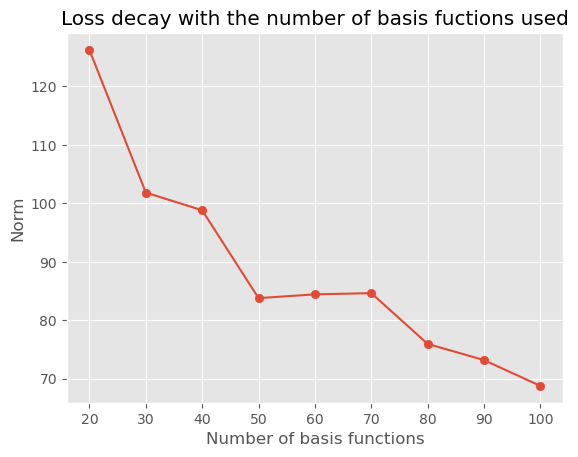

In [14]:
# 我们已经得到了q_table
import matplotlib.pyplot as plt

q_t = []

for i in range(0,Q_TABLE_LEN): 
    for j in range(0,Q_TABLE_LEN):  
        q_t.append([i,j,q_table[i][j][0],q_table[i][j][1],q_table[i][j][2]])
         
q_t=np.array(q_t) 
X = q_t[:, :2] 
y = q_t[:, -3:] 


# RBF
from sklearn.cluster import KMeans
norms =[]
xs =[]
for n in range(20, 101, 10):
    xs.append(n)
    J = n
    kmeans = KMeans(n_clusters=J, random_state=0).fit(X)
    sig = np.std(X)  

    # Construct design matrix
    U = np.zeros((len(q_t),J)) 

    for i in range(len(q_t)): 
        for j in range(J): 
            U[i][j] = np.exp(-np.linalg.norm(X[i] - kmeans.cluster_centers_[j])/sig**2)


    w_rbf = np.dot(np.dot((np.linalg.inv(np.dot(U.T,U))), U.T) , y) # (30, 3)
    yh_rbf = np.dot(U,w_rbf) # N*J    (1600, 3)  

    norm = np.linalg.norm(y-yh_rbf)
    norms.append(norm)
#     print(num_bfs[n],'basis functions: norm', norm )

plt.style.use('ggplot')
fig = plt.gcf()
plt.title('Loss decay with the number of basis fuctions used')
plt.xlabel("Number of basis functions")
plt.ylabel("Norm")
plt.plot(xs, np.array(norms))
plt.scatter(xs, np.array(norms))
plt.show()

### 2 使用Q-learning或SARSA更新规则在线学习RBF逼近的权值，并将结果与表格法进行比较。

0 -14357.0
10 -296.0
20 -288.0
30 -183.0
40 -124.0
50 -124.0
60 -206.0
70 -188.0
80 -190.0
90 -167.0
100 -123.0
110 -122.0
120 -122.0
130 -133.0
140 -135.0
150 -184.0
160 -122.0
170 -133.0
180 -126.0
190 -132.0
200 -132.0
210 -126.0
220 -122.0
230 -122.0
240 -186.0
250 -186.0
260 -175.0
270 -174.0
280 -174.0
290 -173.0
300 -172.0
310 -168.0
320 -170.0
330 -176.0
340 -168.0
350 -171.0
360 -244.0
370 -255.0
380 -178.0
390 -178.0
400 -179.0
410 -257.0
420 -249.0
430 -180.0
440 -180.0
450 -177.0
460 -256.0
470 -171.0
480 -171.0
490 -252.0
500 -174.0
510 -174.0
520 -169.0
530 -167.0
540 -168.0
550 -165.0
560 -165.0
570 -165.0
580 -165.0
590 -165.0
600 -170.0
610 -169.0
620 -127.0
630 -127.0
640 -127.0
650 -118.0
660 -170.0
670 -169.0
680 -169.0
690 -166.0
700 -124.0
710 -124.0
720 -124.0
730 -124.0
740 -124.0
750 -126.0
760 -126.0
770 -126.0
780 -126.0
790 -126.0
800 -176.0
810 -176.0
820 -169.0
830 -124.0
840 -171.0
850 -124.0
860 -169.0
870 -124.0
880 -124.0
890 -124.0
900 -124.0
910 -124

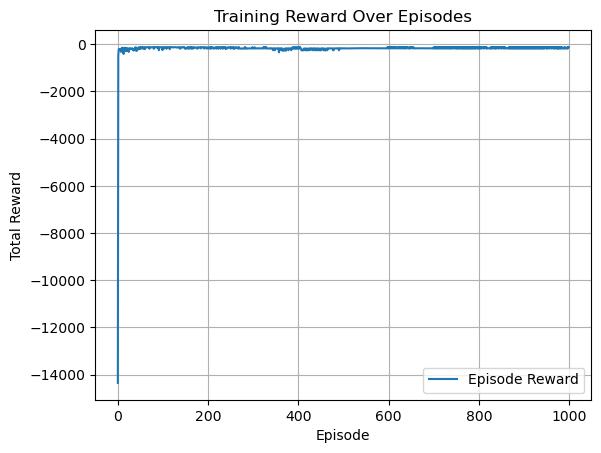

训练结束


In [4]:
# gym enviroment setup
import gym
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


# 添加渲染（render_mode="human"）的情况下，训练时间过长（EPISODE=100情况下，约训练30-40min）。若想观察训练过程，可以设置较小的EPISODE（如10），同时注释env.render()。
# env = gym.make("MountainCar-v0", render_mode="human")    
env = gym.make("MountainCar-v0")   
# env = env.unwrapped
# env.seed(1)
np.random.seed(0)
env.reset()

# Q Table setup
LEARNING_RATE = 0.005
GAMMA = 0.99
EPISODES = 1000
SHOW_EVERY = 200
N_STATE = 20
J = 10 # number of new features, or higher dimensions of the input space, or the number of hidden layers

DISCRETE_OS_SIZE = [N_STATE] * len(env.observation_space.high) 
# [20] * 2 = [20, 20]
discrete_os_win_size = (env.observation_space.high - env.observation_space.low) / DISCRETE_OS_SIZE
# discrete_os_win_size = array([0.09 , 0.007])


# decay epsilon
epsilon = 1
START_EPSILON_DECAYING = 1
END_EPSILON_DECAYING = EPISODES // 2 # //表示整数除法
epsilon_decay_value = epsilon / (END_EPSILON_DECAYING - START_EPSILON_DECAYING)

def get_discrete_state(state):
    discrete_state = (state - env.observation_space.low) // discrete_os_win_size
    return tuple(discrete_state.astype(int))

def take_epsilon_greedy_RBFaction(feature_vec, theta, epsilon):
    if np.random.random() < epsilon: # epsilon decay from 1 to very small
        action = np.random.randint(0, env.action_space.n)
    else:
        action = np.argmax(np.dot(feature_vec,theta)) # 20 * (20*3)
    return action

def get_feature_vec(state, U):
    index = get_discrete_state(state)[0] * N_STATE + get_discrete_state(state)[1] +1
    feature_vec = U[index]
    return feature_vec

def get_design_matrix():
    X = []
    for i in range(0,N_STATE): 
        for j in range(0,N_STATE): 
            X.append ([i,j])
    X=np.array(X) 

    # RBF
    kmeans = KMeans(n_clusters=J, random_state=0).fit(X) 
    sig = np.std(X)  
    
    # build design matrix for X
    U = np.zeros((len(X),J))  

    for i in range(len(X)): 
        for j in range(J): 
            U[i][j] = np.exp(-np.linalg.norm(X[i] - kmeans.cluster_centers_[j])/sig**2)

    return U

def q_learning(env, episodes, discount, epsilon, lr):
    U = get_design_matrix()

    """初始化 theta，这是我们需要通过update来最终学习的东西"""
    theta = np.zeros((J, env.action_space.n)) 
    
    ep_reward = []
    for episode in range(episodes):
        state,_ = env.reset(seed=1)
        total_reward=0
        while(True): # 每个steps 
            feature_vec_u = get_feature_vec(state,U)

            action = take_epsilon_greedy_RBFaction(feature_vec_u, theta, epsilon)
            
                        
            next_state, reward, done, _, info = env.step(action)
            total_reward +=reward
            
            next_feature_vec = get_feature_vec(next_state,U)
            best_next_action = np.argmax(np.dot(next_feature_vec,theta))

            """update theta， 这里需要注意一下，环境当中是对于一个特定action得到1个reward，所以更新的结果是y matrix的特定q，而不是所有q"""
            Q = np.dot(feature_vec_u, theta[:,action]) # q-value for action 
            next_Q = np.dot(next_feature_vec, theta[:,best_next_action]) # q-value for next action
            
            dTheta = lr * (reward + GAMMA * next_Q - Q) # 一个数

            
            """ 更新theta，注意这里的加法"""
            theta[:,action] += dTheta*feature_vec_u
            
            if done: 
                ep_reward.append(total_reward)
                break
            
            state = next_state
            
            
            if episode >= START_EPSILON_DECAYING and episode <= END_EPSILON_DECAYING:
                epsilon -= epsilon_decay_value
        if episode % 10 == 0: print(episode, ep_reward[-1])

    # 绘制奖励曲线
    plt.plot(ep_reward, label='Episode Reward')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Training Reward Over Episodes')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return theta

# 训练模型
theta = q_learning(env, EPISODES, GAMMA, epsilon, LEARNING_RATE)

# 保存训练好的参数，方便后续测试
#print("Theta values:\n", theta)
np.save("../model/trained_theta.npy", theta)

print("训练结束")

In [5]:
def mountain_car_render(theta, max_steps=200):
    U = get_design_matrix()
    state, _ = env.reset(seed=1)
    step = 0
    while True:
        index = get_discrete_state(state)[0] * N_STATE + get_discrete_state(state)[1] + 1
        action = np.argmax(np.dot(U[index], theta))
        next_state, reward, done, truncated, info = env.step(action)
        if env.render_mode == "human":
            env.render()
        step += 1
        # 添加调试信息
        print(f"Step {step}: Position = {next_state[0]}, Done = {done}")
        if done or step > max_steps:
            print(f"Test ended at step {step}, final position: {next_state[0]}, Done = {done}")
            break
        state = next_state
    env.close()

# 使用示例（添加渲染）
env = gym.make("MountainCar-v0", render_mode="human")   

# 直接加载训练好的参数进行测试
theta = np.load("../model/trained_theta.npy")
print("Loaded theta value:", theta)

print("开始测试")
mountain_car_render(theta)



Loaded theta value: [[-14.16293891 -12.51711307 -13.04295181]
 [-12.30559494 -13.33560654 -13.62101582]
 [-10.27720568 -11.2993079   -9.88375265]
 [-11.16730561 -11.31245748  -7.54990392]
 [ -8.53599191 -11.65970464 -11.70789165]
 [-11.88190694 -11.5116078  -12.1154033 ]
 [ -8.35417959 -10.54809244  -9.84162288]
 [-13.36047499 -12.8479433  -12.14719546]
 [-11.69613475 -12.8549061  -12.29937107]
 [-14.47022015 -12.97904299 -13.74451523]]
开始测试
Step 1: Position = -0.49683019518852234, Done = False
Step 2: Position = -0.49522528052330017, Done = False
Step 3: Position = -0.49283289909362793, Done = False
Step 4: Position = -0.48967093229293823, Done = False
Step 5: Position = -0.48576298356056213, Done = False
Step 6: Position = -0.4811381995677948, Done = False
Step 7: Position = -0.475831001996994, Done = False
Step 8: Position = -0.4698808491230011, Done = False
Step 9: Position = -0.46333184838294983, Done = False
Step 10: Position = -0.45623236894607544, Done = False
Step 11: Position